# Sum One, Somewhere 

We seek the values of $p$ for which, when each vertex of an infinite complete binary tree is independently labelled $0$ with probability $p$ and $1$ with probability $1 - p$, the probability that there exists an infinite path from the root down the tree containing at most one vertex labelled $1$ is exactly $\frac{1}{2}$.

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2026)

## 1. Path probabilities

First, we consider the probability $f_0(p)$ that there exists an infinite path containing no ones.

Conditioning on the two branches and applying inclusion–exclusion gives
$$
f_0(p)
= p \left( 2 f_0(p) - f_0(p)^2 \right).
$$

Solving this equation yields
$$
f_0(p) = 2 - \frac{1}{p}.
$$

Now, in general, letting $f_i(p)$ be the probability that there exists an infinite path from the root containing at most $i$ vertices labelled $1$, reasoning as before we obtain that
$$
f_{i+1}(p)
= p \left( 2 f_{i + 1}(p) - f_{i + 1}(p)^2 \right)
+ (1 - p) \left( 2 f_i(p) - f_i(p)^2 \right).
$$

Solving this quadratic equation for $f_{i+1}(p)$ yields

$$
f_{i+1}(p)
= \frac{2 p - 1 \pm \sqrt{(1 - 2p)^2 + 4 p (1 - p) \left( 2 f_i(p) - f_i(p)^2 \right)}}{2p}.
$$


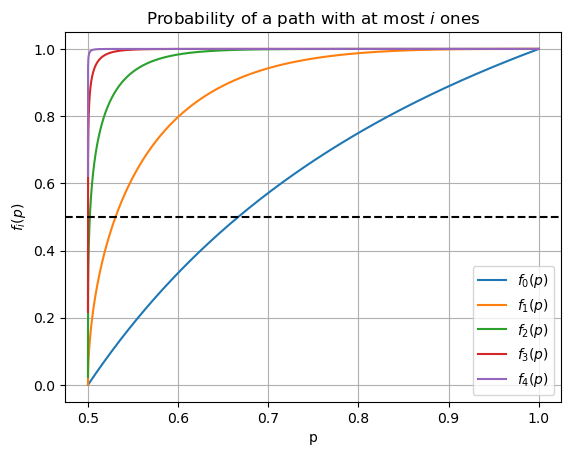

In [2]:
def initial_f(p):
    return 2 - 1/p


def next_f(p, f):
    D = (1 - 2 * p) ** 2 + 4 * p * (1 - p) * (2 * f - f ** 2)
    return (2 * p - 1 + np.sqrt(D)) / (2 * p)


p = np.linspace(0.5 + 1e-8, 1 - 1e-8, 10_000)
f = initial_f(p)
f_values = [f] + [(f := next_f(p, f)) for _ in range(4)]

for i, f in enumerate(f_values):
    plt.plot(p, f, label=f"$f_{i}(p)$")

plt.axhline(0.5, color="black", ls="--")
plt.title("Probability of a path with at most $i$ ones")
plt.xlabel("p")
plt.ylabel(r"$f_i(p)$")
plt.legend()
plt.grid(True)
plt.show()

We observe that the probability is $0$ for $p \leq \frac{1}{2}$, and gets increasingly close to zero as we allow more ones in the path. 

We are interested in the exact point at which
$$
f_1(p) = \frac{1}{2}.
$$

In [3]:
p = sp.symbols('p')
q = sp.Rational(1, 2)
f0 = 2 - 1 / p
eqn = p * (2 * q - q ** 2) + (1 - p) * (2 * f0 - f0 ** 2) - q

p_star = float(next(sol for sol in sp.solve(eqn, p) if sol.is_real))
p_star

0.5306035754300054

We check that this value indeed gives the probability of $\frac{1}{2}$ by running a simulation.

In [4]:
def simulate_tree_at_most_one(p, depth, rng):
    zero = rng.binomial(1, p)  # Number of paths with zero ones
    one = 1 - zero  # Number of paths with exactly one one

    for _ in range(depth):
        if not (zero or one):
            break

        zero_children = 2 * zero
        one_children = 2 * one
        new_zero = rng.binomial(zero_children, p)
        new_one = rng.binomial(one_children, p) + zero_children - new_zero
        zero, one = new_zero, new_one

    return zero + one


def estimate_probability(p, iters, depth, seed=None):
    rng = np.random.default_rng(seed)
    hits = 0
    estimates = np.empty(iters)

    for i in range(iters):
        hits += simulate_tree_at_most_one(p, depth, rng) > 0
        estimates[i] = hits / (i + 1)

    return estimates

In [5]:
count_est = estimate_probability(p_star, 1000000, 100)

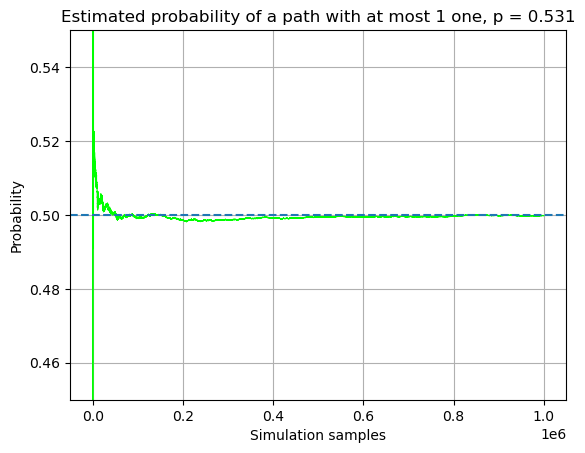

In [6]:
plt.plot(count_est, color="lime", linewidth=0.8)
plt.axhline(0.5, linestyle="--")
plt.ylim(0.45, 0.55)
plt.xlabel("Simulation samples")
plt.ylabel("Probability")
plt.title(f"Estimated probability of a path with at most 1 one, p = {p_star:.3f}")
plt.grid()
plt.show()

## 2. Expected number of paths

Let $X_n$ denote the number of paths consisting entirely of zeros at level $n$. By linearity of expectation, we obtain
$$
E X_n 
= 2^n p^n 
= (2p)^n.
$$

Using the Monotone Convergence Theorem (MCT) or the Dominated Convergence Theorem (DCT), we may exchange the limit and expectation. Therefore, the expected number of paths consisting of all zeroes is
$$
E \left( \lim X_n \right) 
= \lim EX_n 
= \begin{cases}
0, & p < \frac{1}{2}, \\
1, & p = \frac{1}{2}, \\
+\infty, & p > \frac{1}{2}. 
\end{cases}
$$

The most surprising result comes at $p = \frac{1}{2}$, where the probability of a path of all zeroes is exactly zero, but the expected number of paths consisting of all zeroes is one. 

We check this claim by running a simulation.

In [7]:
def simulate_tree(p, depth, rng):
    active = 1

    for _ in range(depth):
        if active == 0:
            break
        active = rng.binomial(2 * active, p)

    return active


def estimate_expectation(p, iters, depth, seed=None):
    rng = np.random.default_rng(seed)
    hits = 0
    estimates = np.empty(iters)

    for i in range(iters):
        hits += simulate_tree(p, depth, rng)
        estimates[i] = hits / (i + 1)

    return estimates

In [8]:
count_est = estimate_expectation(0.5, 1000000, 100)

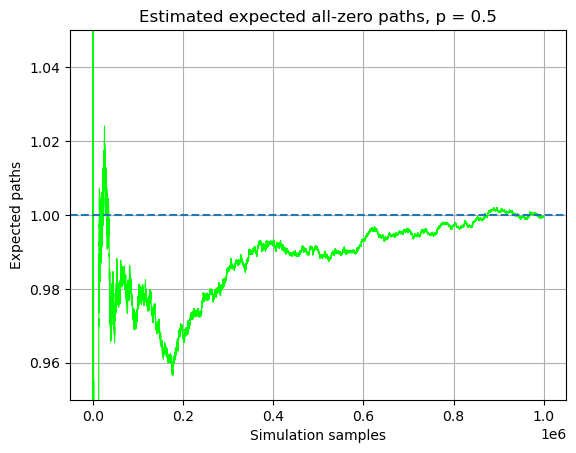

In [9]:
plt.plot(count_est, color="lime", linewidth=0.8)
plt.axhline(1, linestyle="--")
plt.ylim(0.95, 1.05)
plt.xlabel("Simulation samples")
plt.ylabel("Expected paths")
plt.title(f"Estimated expected all-zero paths, p = {.5}")
plt.grid()
plt.show()